<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/wdt_r%C3%A9seaux_relations_professionnelles_fashiondesigners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relations réciproques entres personnes et avec les institutions



In [404]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import display, HTML
import os

In [405]:
!pip install itables
!pip install netgraph

In [406]:
from itables import init_notebook_mode, show
from netgraph import Graph, InteractiveGraph

In [407]:
!pip install pyvis

In [408]:
from pyvis.network import Network

## Production des données

Requête exécutée sur le serveur https://query.wikidata.org/
Propriétés prises en compte après inspection des propriétés de la population : educated at (2134) / member of (191)/ employer (421)



```
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

SELECT DISTINCT ?item ?itemLabel (?year AS ?birthYear) ?r_property ?organisation ?organisationLabel ?coordinates
WHERE {
  {
    { ?item wdt:P106 wd:Q3501317 } # occupation is fashion designer.
    UNION
    { ?item wdt:P101 wd:Q29583 } # field of work is fashion design    
    ?item wdt:P31 wd:Q5; # Any instance of a human.
          wdt:P569 ?birthDate.
    BIND(REPLACE(str(?birthDate), "(.*)([0-9]{4})(.*)", "$2") AS ?year)
    FILTER(xsd:integer(?year) > 1800 && xsd:integer(?year) < 2001)

    {
      { ?item wdt:P463 ?organisation.
        BIND('member_of' AS ?r_property) }
      UNION  
      { ?item wdt:P69 ?organisation.
        BIND('educated_at' AS ?r_property) }
      UNION  
      { ?item wdt:P108 ?organisation.
        BIND('employer' AS ?r_property) }
    }
      
    OPTIONAL { ?organisation wdt:P625 ?coordinates }
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
  }
}
ORDER BY ?year

```



In [409]:
### Ouvrir le fichier et créer un DataFrame
fd = '/content/drive/MyDrive/dossier de travail/wdt_analyse_reseaux.csv'
df = pd.read_csv(fd)
len(df)

2667

In [410]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'employer' ajouté une période d'activité de 19 à 65 ans
df['YBegin'] = df[['birthYear', 'r_property']].apply(lambda x : int(x['birthYear'] + 17) if x['r_property'] == 'educated_at' else int(x['birthYear'] + 27), axis=1)
df['YEnd'] = df[['birthYear', 'r_property']].apply(lambda x : int(x['birthYear'] + 28) if x['r_property'] == 'employer' else int(x['birthYear'] + 64), axis=1)

In [411]:
### Inspecter DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item               2667 non-null   object
 1   itemLabel          2667 non-null   object
 2   birthYear          2667 non-null   int64 
 3   r_property         2667 non-null   object
 4   organisation       2667 non-null   object
 5   organisationLabel  2667 non-null   object
 6   coordinates        2073 non-null   object
 7   YBegin             2667 non-null   int64 
 8   YEnd               2667 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 187.6+ KB


In [412]:
### Inspecter la distribution des années de naissance
df.birthYear.describe()

count                2667.0
mean      1958.931008623922
std      28.303820699007954
min                  1805.0
25%                  1945.0
50%                  1966.0
75%                  1980.0
max                  2000.0
Name: birthYear, dtype: float64

In [413]:
df.tail()

,item,itemLabel,birthYear,r_property,organisation,organisationLabel,coordinates,YBegin,YEnd
2662,http://www.wikidata.org/entity/Q118082384,Javi Guijarro,2000,employer,http://www.wikidata.org/entity/Q22001324,Karol G,NaN,2027,2028
2663,http://www.wikidata.org/entity/Q118082384,Javi Guijarro,2000,employer,http://www.wikidata.org/entity/Q25432114,Bad Gyal,NaN,2027,2028
2664,http://www.wikidata.org/entity/Q118082384,Javi Guijarro,2000,employer,http://www.wikidata.org/entity/Q61586861,Rauw Alejandro,NaN,2027,2028
2665,http://www.wikidata.org/entity/Q114051014,Giulia Frangiluna,2000,educated_at,http://www.wikidata.org/entity/Q5518,liceo classico,NaN,2017,2064
2666,http://www.wikidata.org/entity/Q118082384,Javi Guijarro,2000,educated_at,http://www.wikidata.org/entity/Q5397540,"Esdi, Escola Superior de Disseny",Point(2.1165 41.5436),2017,2064


In [414]:
## intégrer la table dans la base de données --> ( table wdt_relations)
### nettoyer les données

# Beaucoup d'écoles/universités ont fusionné et changé de nom au cours du temps--> harmoniser avec un seul nom ?
#New York University < = New York University Institute of Fines Arts


In [415]:
### Compter par propriété
df.groupby(by='r_property').size()

r_property
educated_at    2101
employer        377
member_of       189
dtype: int64

In [416]:
organisations = df.groupby(by='organisationLabel').size()
show(organisations.sort_index(ascending=False))

In [417]:
### Effectif total et les plus représentées
len(organisations), organisations.sort_values(ascending=False).head(10)

(1589,
 organisationLabel
 Parsons School of Design                       73
 Central Saint Martins                          61
 Fashion Institute of Technology                53
 Royal College of Art                           27
 Royal Academy of Fine Arts                     25
 London College of Fashion                      21
 Bunka Fashion College                          19
 Fashion Institute of Design & Merchandising    17
 Saint Martin's School of Art                   17
 Beaux-Arts de Paris                            13
 dtype: int64)

### Coder les périodes

In [418]:
bins=[1801,1921,1971,2021]

In [419]:
df['periode'] = pd.cut(df['birthYear'], bins=bins, right=False  )
df.periode = df.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [420]:
df.head()

,item,itemLabel,birthYear,r_property,organisation,organisationLabel,coordinates,YBegin,YEnd,periode
0,http://www.wikidata.org/entity/Q62128099,August Mannerheim,1805,employer,http://www.wikidata.org/entity/Q194060,Bank of Finland,NaN,1832,1833,1801_1921
1,http://www.wikidata.org/entity/Q5363058,Elizabeth Keckley,1818,employer,http://www.wikidata.org/entity/Q215062,Mary Todd Lincoln,NaN,1845,1846,1801_1921
2,http://www.wikidata.org/entity/Q64876982,John Redfern,1820,employer,http://www.wikidata.org/entity/Q7305826,Redfern,NaN,1847,1848,1801_1921
3,http://www.wikidata.org/entity/Q106151771,Madeleine Laferrière,1825,employer,http://www.wikidata.org/entity/Q3278826,Maison Laferrière,NaN,1852,1853,1801_1921
4,http://www.wikidata.org/entity/Q1255520,Alfred Isidore Römer,1832,educated_at,http://www.wikidata.org/entity/Q414052,"Academy of Fine Arts, Munich",Point(11.580312391 48.15319592),1849,1896,1801_1921


In [421]:
### Effectif par période
df.groupby(by='periode').size()

periode
1801_1921     272
1921_1971    1266
1971_2021    1129
dtype: int64

In [422]:
### Dataframe to dictionary
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
ldf = df[['itemLabel', 'r_property', 'organisationLabel',
       'YBegin', 'YEnd', 'birthYear', 'periode']].sort_values(by='itemLabel').to_dict('records')

In [423]:
ldf[:2]

[{'itemLabel': 'ASAP Bari',
  'r_property': 'member_of',
  'organisationLabel': 'ASAP Mob',
  'YBegin': 2018,
  'YEnd': 2055,
  'birthYear': 1991,
  'periode': '1971_2021'},
 {'itemLabel': 'Aarni Soivio',
  'r_property': 'educated_at',
  'organisationLabel': 'Sibelius Upper Secondary School',
  'YBegin': 2014,
  'YEnd': 2061,
  'birthYear': 1997,
  'periode': '1971_2021'}]

## Graphe à deux types de sommets

Il s'agit d'un graphe de type 'bipartite', cf. la documentation de Networkx:

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

Nous n'utilisons toutefois pas ici les fonctions spécifiques de Neworkx.

In [424]:
l = []
for i in ldf:
    if i['periode'] == '1801_1921':
        l.append(tuple((i['itemLabel'],i['organisationLabel'],
                        {'relationship': i['r_property'], "birth_year": i['birthYear'], "periode": i['periode'] })))
l[:5]

[('Addie Masters',
  'Affiliated Fashionists',
  {'relationship': 'member_of', 'birth_year': 1901, 'periode': '1801_1921'}),
 ('Adele Filene',
  'Jantzen',
  {'relationship': 'employer', 'birth_year': 1909, 'periode': '1801_1921'}),
 ('Adele Filene',
  'Vogue Pattern Company',
  {'relationship': 'employer', 'birth_year': 1909, 'periode': '1801_1921'}),
 ('Adolf Dassler',
  'Adidas AG',
  {'relationship': 'employer', 'birth_year': 1900, 'periode': '1801_1921'}),
 ('Adrian',
  'Parsons School of Design',
  {'relationship': 'educated_at', 'birth_year': 1903, 'periode': '1801_1921'})]

In [425]:
# Graphe Personne-Organisation
POG=nx.Graph()

In [426]:
POG.add_edges_from(l)

In [427]:
### Principales caractéristiques de ce graphe

POG.is_multigraph(), POG.is_directed(), nx.is_connected(POG), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)

(False, False, False, 369, 263, 0.0038735713444090964)

In [428]:
### Créer une liste des organisations
l_org = list(organisations.index); len(l_org); l_org[:6]

['1st State Duma of the Russian Federation',
 '20th Century Studios',
 '2nd State Duma of the Russian Federation',
 '3rd State Duma of the Russian Federation',
 '43 Group',
 'ABLF alumni network']

In [429]:
list(POG.nodes.data())[:4]

[('Addie Masters', {}),
 ('Affiliated Fashionists', {}),
 ('Adele Filene', {}),
 ('Jantzen', {})]

In [430]:
### Ajouter au sommets un code si personne ou organisation
# On utiliser pour ce faire la liste des organisations
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t}
[(k,v )for k,v in types.items()][:3]

[('Addie Masters', {'type': 'P'}),
 ('Affiliated Fashionists', {'type': 'O'}),
 ('Adele Filene', {'type': 'P'})]

In [431]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Addie Masters', {'type': 'P'}),
 ('Affiliated Fashionists', {'type': 'O'}),
 ('Adele Filene', {'type': 'P'})]

## Inspecter les centralités de degré

" La centralité de degré repose sur le nombre de connexions directes que possède un nœud. Vous devez l’utiliser pour déterminer quels nœuds ont le plus d’influence directe. Par exemple, dans un réseau social, les utilisateurs qui ont le plus grand nombre de connexions bénéficient d’une centralité de degré plus élevée."

https://doc.arcgis.com/fr/insights/latest/analyze/link-analysis.htm#:~:text=La%20centralit%C3%A9%20de%20degr%C3%A9%20repose,centralit%C3%A9%20de%20degr%C3%A9%20plus%20%C3%A9lev%C3%A9e.

---



In [432]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [433]:
nx.set_node_attributes(POG, degree)

In [434]:
print(list(POG.nodes.data())[:4])

[('Addie Masters', {'type': 'P', 'degree': 1}), ('Affiliated Fashionists', {'type': 'O', 'degree': 1}), ('Adele Filene', {'type': 'P', 'degree': 2}), ('Jantzen', {'type': 'O', 'degree': 1})]


In [435]:
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

In [436]:
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['Russell Patterson', 14],
 ['Marie von Geldern-Egmond', 8],
 ['Siri Derkert', 7],
 ['Vera Mukhina', 7],
 ['Edith Head', 4],
 ['Heddi Hirsch', 4],
 ['Hugo Boss', 4],
 ['Jutta Sika', 4],
 ['Osceola Macarthy Adams', 4],
 ['Aili-Salli Ahde-Kjäldman', 3]]

In [437]:
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

In [438]:
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['Parsons School of Design', 8],
 ['Art Students League of New York', 6],
 ['University of Applied Arts Vienna', 6],
 ['Wiener Werkstätte', 6],
 ['Beaux-Arts de Paris', 5],
 ['Pratt Institute', 3],
 ['Académie de La Palette', 3],
 ['Académie de la Grande Chaumière', 3],
 ['Konstfack', 2],
 ['Deutscher Werkbund', 2]]

In [439]:
edges = list(POG.edges.data())
edges[:5]

[('Addie Masters',
  'Affiliated Fashionists',
  {'relationship': 'member_of', 'birth_year': 1901, 'periode': '1801_1921'}),
 ('Adele Filene',
  'Jantzen',
  {'relationship': 'employer', 'birth_year': 1909, 'periode': '1801_1921'}),
 ('Adele Filene',
  'Vogue Pattern Company',
  {'relationship': 'employer', 'birth_year': 1909, 'periode': '1801_1921'}),
 ('Adolf Dassler',
  'Adidas AG',
  {'relationship': 'employer', 'birth_year': 1900, 'periode': '1801_1921'}),
 ('Adrian',
  'Parsons School of Design',
  {'relationship': 'educated_at', 'birth_year': 1903, 'periode': '1801_1921'})]

In [440]:
labels = {}
for node in POG.nodes():
    labels[node] = node

In [441]:
nx.set_node_attributes(POG, labels, 'label')

In [442]:
nodes = list(POG.nodes.data())
nodes[:5]

[('Addie Masters', {'type': 'P', 'degree': 1, 'label': 'Addie Masters'}),
 ('Affiliated Fashionists',
  {'type': 'O', 'degree': 1, 'label': 'Affiliated Fashionists'}),
 ('Adele Filene', {'type': 'P', 'degree': 2, 'label': 'Adele Filene'}),
 ('Jantzen', {'type': 'O', 'degree': 1, 'label': 'Jantzen'}),
 ('Vogue Pattern Company',
  {'type': 'O', 'degree': 1, 'label': 'Vogue Pattern Company'})]

## Analyser les composantes du graphe
Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [443]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(112, [44, 16, 15, 10, 10])

In [444]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [445]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[3, 44], [33, 16], [90, 15], [7, 10], [42, 10], [31, 7], [49, 5], [61, 5]]

In [446]:
li=[n[0] for n in ln]

In [447]:
S[21].nodes

NodeView(('Harrow School', 'Charles James'))

## Représenter le graphe

In [448]:
u = S[14]

In [449]:
u = nx.Graph()
for i in li[:15]:
    u = nx.union(u, S[i])

In [450]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)

(False, False, 141, 132, 0.013373860182370821)

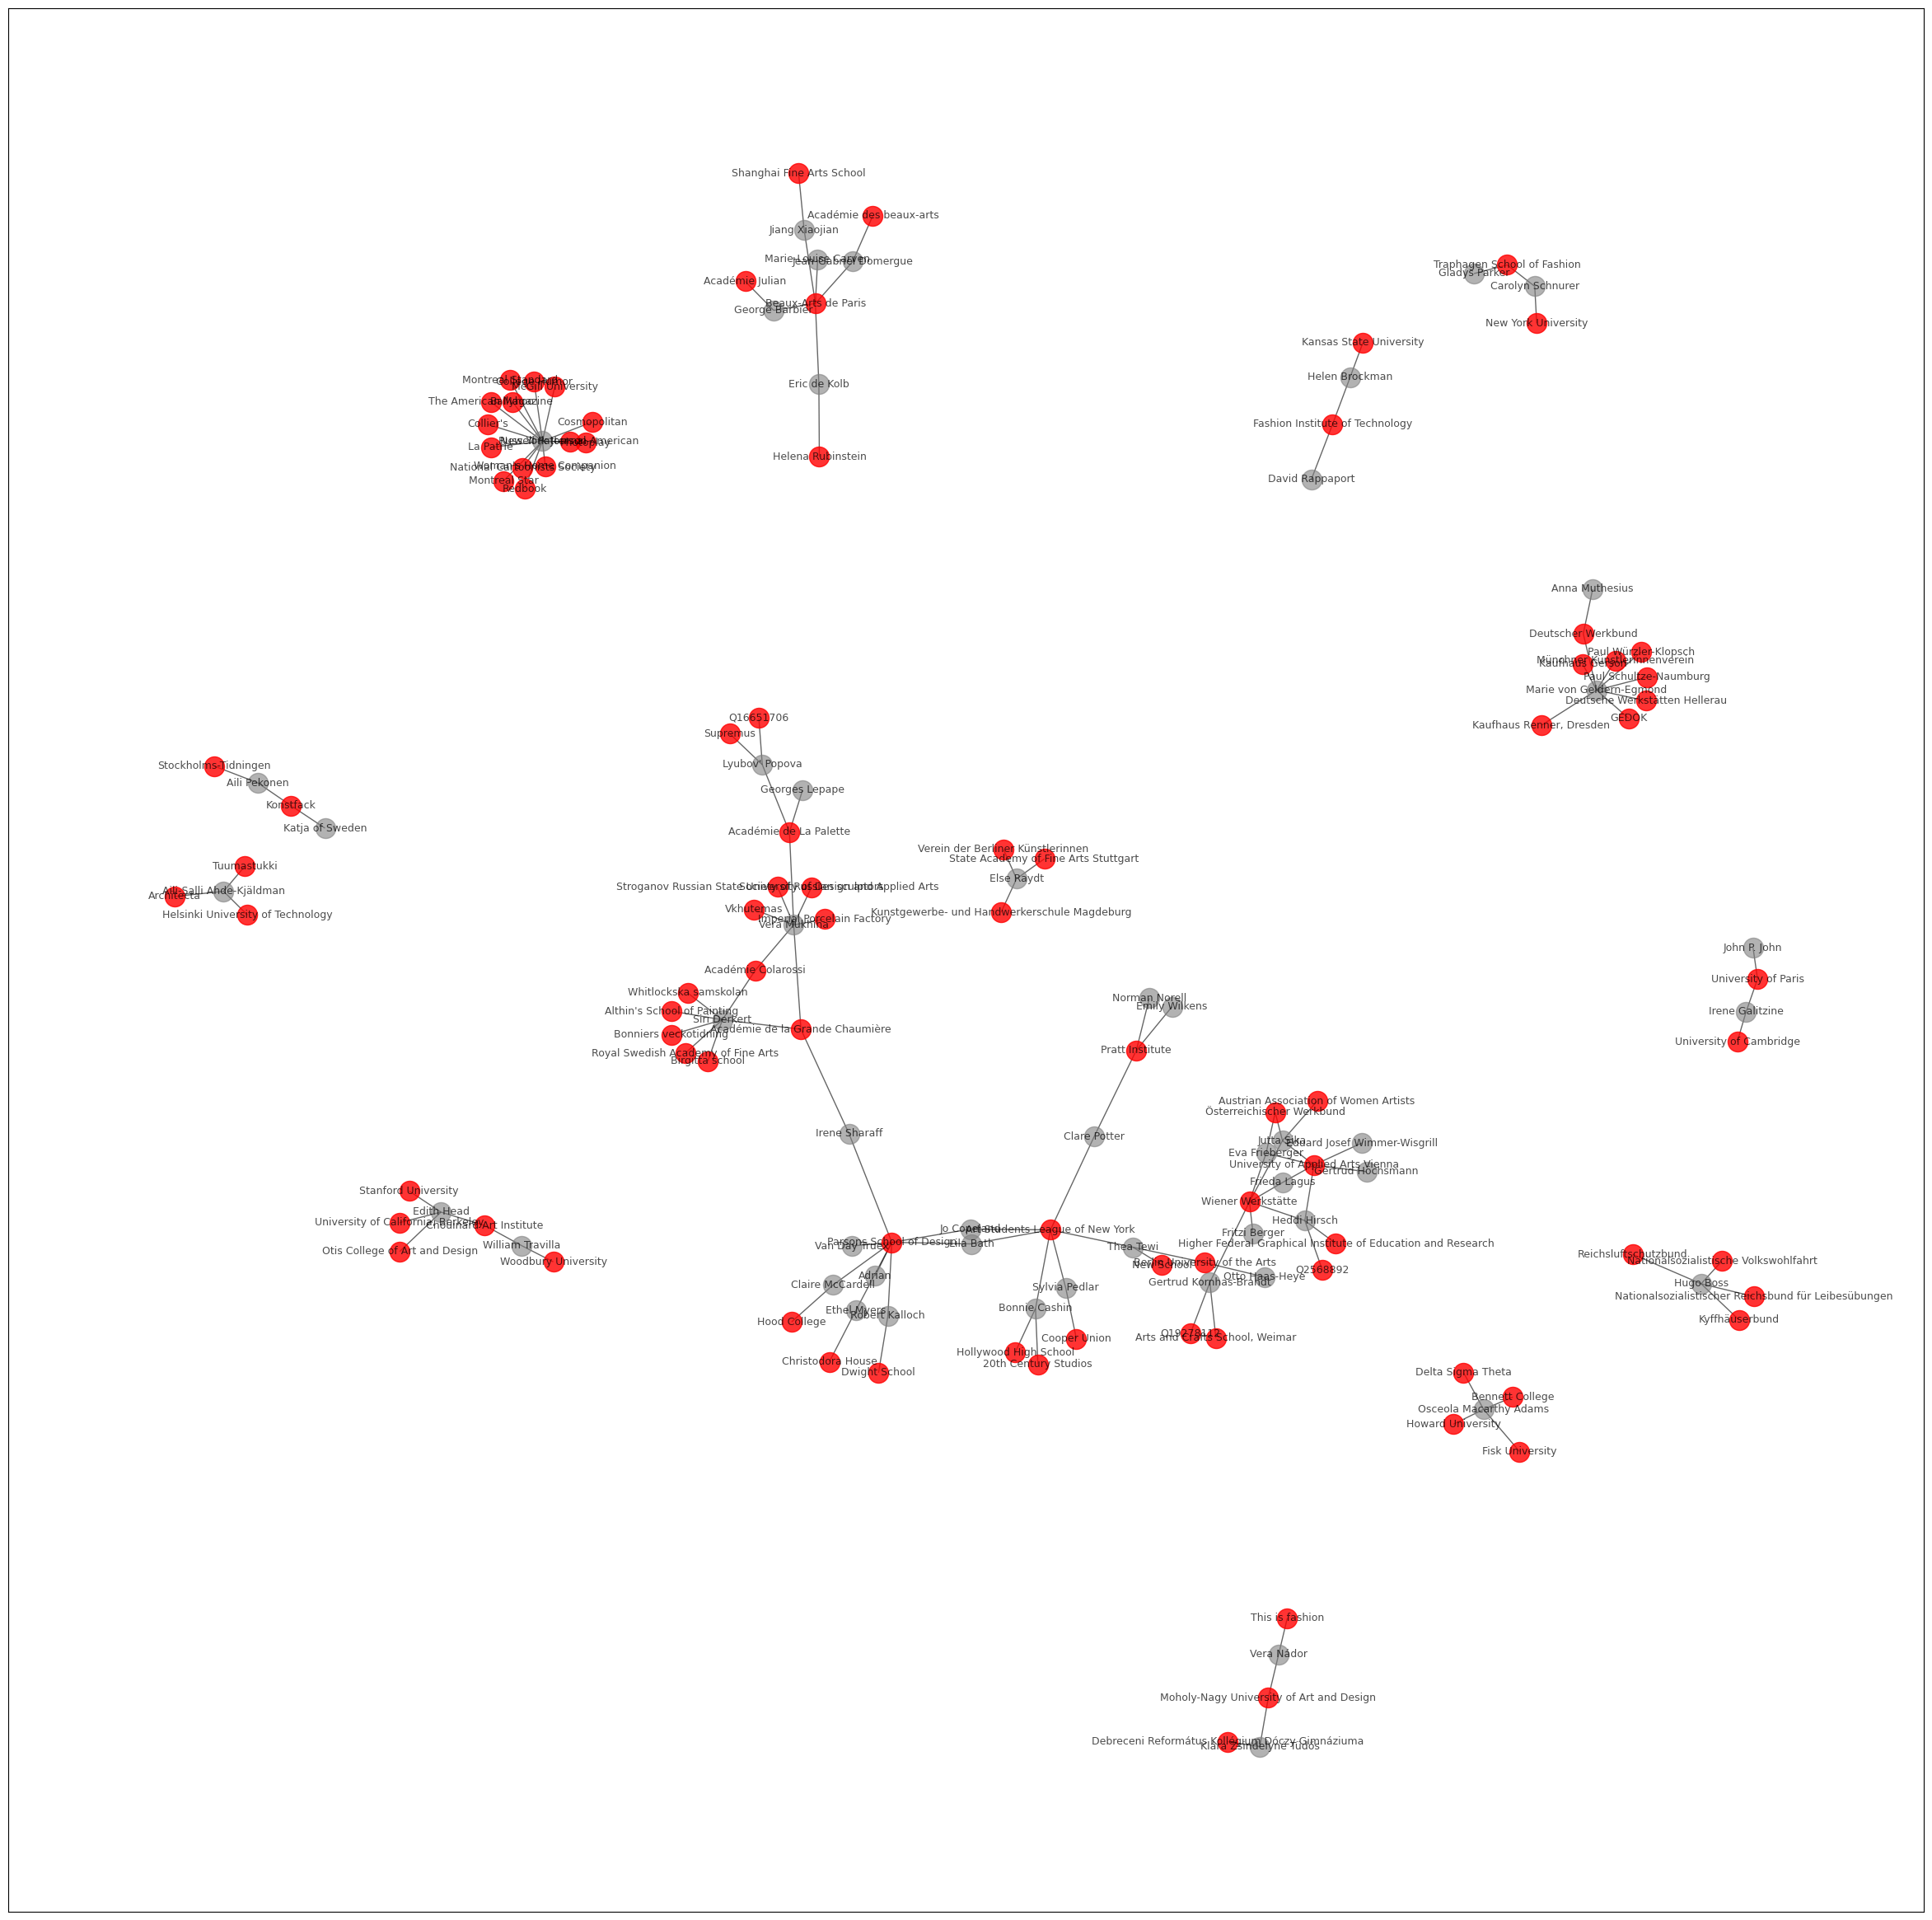

In [451]:
### Visualiser les 15 composantes principales entre personnes et organisations (membres de / employé par ou étudié à)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P']

co = 'red'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)


plt.show()

**Commentaire**

On observe ici que le graph n'est pas connecté, mais formé de diverses composantes. Il y a donc des îlots de réseaux Personnes-Organisations.

Il y a quelques connexions entre les réseaux français, anglais et américains.




In [452]:
###
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network(notebook=True, cdn_resources='remote')
# populates the nodes and edges data structures
nt.from_nx(g)
nt.prep_notebook()
# Générer le fichier HTML contenant la visualisation
# nt.show('pictures.html' )
# display(HTML('pictures.html'))


### Créer les paires de personnes

Personnes ayant étudié dans la même université ou travaillé chez le même employeur à la même époque:

* on teste si c'est la même université

* on teste s'il y a superposition des périodes

In [453]:
### Paires de personnes
pairs_p = []

for s1 in ldf:
    for s2 in ldf:
        if s1['itemLabel'] < s2['itemLabel'] \
            and s1['organisationLabel'] == s2['organisationLabel'] \
            and s2['YEnd'] > s1['YBegin'] \
            and s2['YBegin'] < s1['YEnd']:
            pairs_p.append([s1,s2])
        else:
            pass

In [454]:
len(pairs_p)

7569

In [455]:
pairs_p[:2]

[[{'itemLabel': 'Abderrahmane Trabsini',
   'r_property': 'educated_at',
   'organisationLabel': 'Royal Academy of Art',
   'YBegin': 2006,
   'YEnd': 2053,
   'birthYear': 1989,
   'periode': '1971_2021'},
  {'itemLabel': 'Hilde Sinke',
   'r_property': 'educated_at',
   'organisationLabel': 'Royal Academy of Art',
   'YBegin': 1992,
   'YEnd': 2039,
   'birthYear': 1975,
   'periode': '1971_2021'}],
 [{'itemLabel': 'Abderrahmane Trabsini',
   'r_property': 'educated_at',
   'organisationLabel': 'Royal Academy of Art',
   'YBegin': 2006,
   'YEnd': 2053,
   'birthYear': 1989,
   'periode': '1971_2021'},
  {'itemLabel': 'Lotte van Laatum',
   'r_property': 'educated_at',
   'organisationLabel': 'Royal Academy of Art',
   'YBegin': 1996,
   'YEnd': 2043,
   'birthYear': 1979,
   'periode': '1971_2021'}]]

### Créer les paires d'organisations
Une personne fait le lien entre deux organisations

In [456]:
## Paires d'organisations
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['organisationLabel'] < s2['organisationLabel'] \
            and s1['itemLabel'] == s2['itemLabel']:
                pairs_o.append([s1,s2])
        else:
            pass

In [457]:
len(pairs_o)

2430

In [458]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'itemLabel': 'Aarni Soivio',
   'r_property': 'member_of',
   'organisationLabel': 'Kuumaa',
   'YBegin': 2024,
   'YEnd': 2061,
   'birthYear': 1997,
   'periode': '1971_2021'},
  {'itemLabel': 'Aarni Soivio',
   'r_property': 'educated_at',
   'organisationLabel': 'Sibelius Upper Secondary School',
   'YBegin': 2014,
   'YEnd': 2061,
   'birthYear': 1997,
   'periode': '1971_2021'}],
 [{'itemLabel': 'Abiodun Folashade Tokunbo',
   'r_property': 'educated_at',
   'organisationLabel': 'Lagos State University',
   'YBegin': 1997,
   'YEnd': 2044,
   'birthYear': 1980,
   'periode': '1971_2021'},
  {'itemLabel': 'Abiodun Folashade Tokunbo',
   'r_property': 'educated_at',
   'organisationLabel': 'The Polytechnic, Ibadan',
   'YBegin': 1997,
   'YEnd': 2044,
   'birthYear': 1980,
   'periode': '1971_2021'}]]

## Réseaux de personnes ayant étudié ou travaillé dans la même institution à la même époque (filtres, sous-populations)

In [459]:
XIX_XX_pairs = [p for p in pairs_p if ((p[0]['periode']=='1801_1921') & (p[1]['periode']=='1801_1921'))]

In [460]:
len(XIX_XX_pairs), XIX_XX_pairs[:3]

(98,
 [[{'itemLabel': 'Adrian',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1920,
    'YEnd': 1967,
    'birthYear': 1903,
    'periode': '1801_1921'},
   {'itemLabel': 'Claire McCardell',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1922,
    'YEnd': 1969,
    'birthYear': 1905,
    'periode': '1801_1921'}],
  [{'itemLabel': 'Adrian',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1920,
    'YEnd': 1967,
    'birthYear': 1903,
    'periode': '1801_1921'},
   {'itemLabel': 'Ethel Myers',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1898,
    'YEnd': 1945,
    'birthYear': 1881,
    'periode': '1801_1921'}],
  [{'itemLabel': 'Adrian',
    'r_property': 'educated_at',
    'organisationLabel': 'Parsons School of Design',
    'YBegin': 1920,
    'YEnd': 1967,
    'birthYear'

In [461]:
almaMater_pairs = [p for p in pairs_p if ((p[0]['r_property'] == 'educated_at') & (p[1]['r_property'] == 'educated_at'))]

In [462]:
len(almaMater_pairs), almaMater_pairs[:2]

(7201,
 [[{'itemLabel': 'Abderrahmane Trabsini',
    'r_property': 'educated_at',
    'organisationLabel': 'Royal Academy of Art',
    'YBegin': 2006,
    'YEnd': 2053,
    'birthYear': 1989,
    'periode': '1971_2021'},
   {'itemLabel': 'Hilde Sinke',
    'r_property': 'educated_at',
    'organisationLabel': 'Royal Academy of Art',
    'YBegin': 1992,
    'YEnd': 2039,
    'birthYear': 1975,
    'periode': '1971_2021'}],
  [{'itemLabel': 'Abderrahmane Trabsini',
    'r_property': 'educated_at',
    'organisationLabel': 'Royal Academy of Art',
    'YBegin': 2006,
    'YEnd': 2053,
    'birthYear': 1989,
    'periode': '1971_2021'},
   {'itemLabel': 'Lotte van Laatum',
    'r_property': 'educated_at',
    'organisationLabel': 'Royal Academy of Art',
    'YBegin': 1996,
    'YEnd': 2043,
    'birthYear': 1979,
    'periode': '1971_2021'}]])

## Exploration des graphes de personnes

### Période 1801-1921

In [463]:
### Préparer pour créer le graphe
l = []
for i in XIX_XX_pairs: #personnes ayan étudié aux mêmes insitutions  pour la période 1801-1921
    l.append(tuple((i[0]['itemLabel'],i[1]['itemLabel'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}",
                                                              'organisation': i[0]['organisationLabel'] })))
l[:7]

[('Adrian',
  'Claire McCardell',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Ethel Myers',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Irene Sharaff',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Jo Copeland',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Lila Bath',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Robert Kalloch',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Van Day Truex',
  {'relationship': 'educated_at_employer',
   'organisation': 'Parsons School of Design'})]

In [464]:
EMP=nx.Graph()

In [465]:
EMP.add_edges_from(l)

In [466]:
### Principales caractéristiques de ce graphe

EMP.is_multigraph(), EMP.is_directed(), nx.is_connected(EMP), EMP.number_of_nodes(), EMP.number_of_edges(), nx.density(EMP)

(False, False, False, 49, 86, 0.07312925170068027)

In [467]:
nodes = list(EMP.nodes.data())
nodes[:5]

[('Adrian', {}),
 ('Claire McCardell', {}),
 ('Ethel Myers', {}),
 ('Irene Sharaff', {}),
 ('Jo Copeland', {})]

In [468]:
edges = list(EMP.edges.data())
edges[:5]

[('Adrian',
  'Claire McCardell',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Ethel Myers',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Irene Sharaff',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Jo Copeland',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrian',
  'Lila Bath',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'})]

In [469]:
labels = {}
for node in EMP.nodes():
    labels[node] = node

In [470]:
###
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
# Créer un objet Network de PyVis avec l'option cdn_resources='remote'
nt = Network(notebook=True, cdn_resources='remote')
# populates the nodes and edges data structures
nt.from_nx(EMP)
nt.prep_notebook()
# Générer le fichier HTML contenant la visualisation
#nt.show('graph.html')
#display(HTML('graph.html'))


**Commentaire**

On voit que le graphe est peu connecté. Il existe des îlots par région, en Europe et en Amérique du Nord.

### Analyser les composantes du graphe
Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [471]:
nx.is_connected(EMP)

False

In [472]:
# filtre qui va chercher les composantes qui sont connectées --> liste des composantes qui se trouve ds la variable component
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]
## résultat: 12 composantes

(12, [18, 8, 5, 2, 2])

In [473]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]
# création d'une liste des sous-graph

In [474]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]
#parcourir ces sous-graph et les "cuisiner"

[[0, 18], [5, 8], [6, 5], [1, 2], [2, 2], [3, 2], [4, 2], [7, 2]]

In [475]:
li=[n[0] for n in ln]
## résultats dans l'ordre des effectifs


### Représenter le graphe

In [476]:
u = nx.Graph()
for i in li[0:2]:
    u = nx.union(u, S[i])

In [477]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)

(False, False, 26, 67, 0.20615384615384616)

In [478]:
u = S[5]

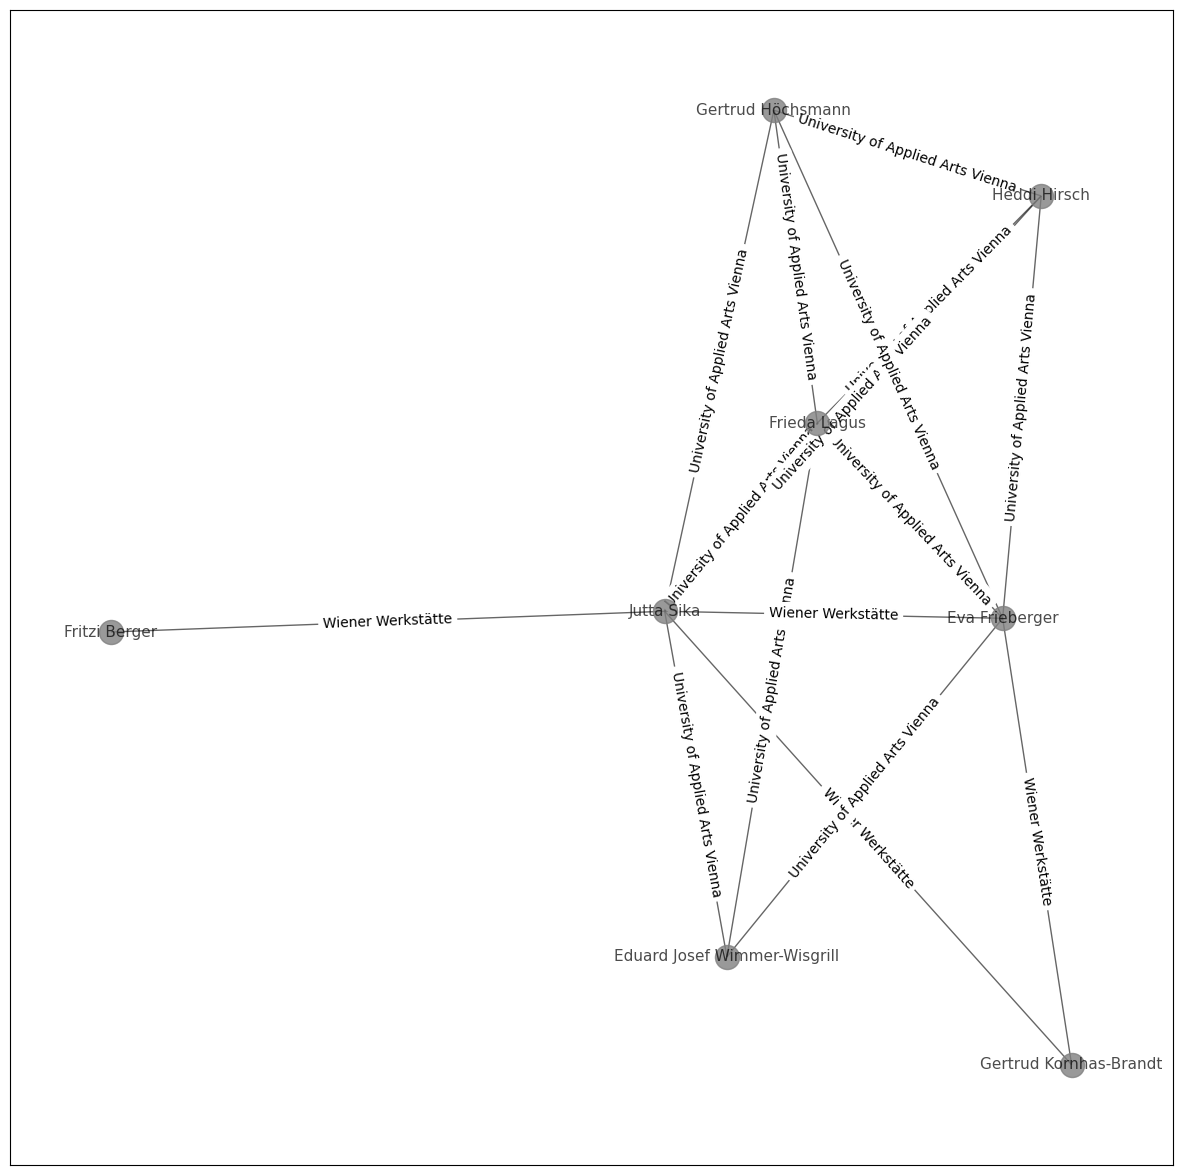

In [479]:
# https://networkx.org/documentation/stable/reference/drawing.html


plt.figure(figsize = (15,15))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

pos = nx.spring_layout(u, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

# Vérification et création du répertoire 'images' si nécessaire
os.makedirs('images', exist_ok=True)

# Enregistrement de l'image
f_address = "images/XIX_XX_pairs_1.png"
plt.savefig(f_address)

# Affichage de l'image
plt.show()

**Commentaire**

On voit s'afficher une des composantes du graph qui permet de visualiser les réseaux viennois liés à la création de mode.

On constate l'omniprésence de l'Université d'Arts appliqués de Vienne et du mouvement de la Scécession viennoise.

### Période1921_1971

In [480]:
early20_pairs = [p for p in pairs_p if ((p[0]['periode']=='1921_1971') & (p[1]['periode']=='1921_1971'))]

In [481]:
### Préparer pour créer le graphe
l1 = []
for i in early20_pairs: #lien général personne à personne
    l1.append(tuple((i[0]['itemLabel'],i[1]['itemLabel'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}",
                                                              'organisation': i[0]['organisationLabel'] })))
l1[:5]

[('Adrienne Steckling-Coen',
  'Alfred Sung',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Anna Sui',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Bill Blass',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Carine Roitfeld',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Christian Francis Roth',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'})]

In [482]:
EMP1=nx.Graph()

In [483]:
EMP1.add_edges_from(l1)

In [484]:
nodes = list(EMP1.nodes.data())
nodes[:5]

[('Adrienne Steckling-Coen', {}),
 ('Alfred Sung', {}),
 ('Anna Sui', {}),
 ('Bill Blass', {}),
 ('Carine Roitfeld', {})]

In [485]:
edges = list(EMP1.edges.data())
edges[:5]

[('Adrienne Steckling-Coen',
  'Alfred Sung',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Anna Sui',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Bill Blass',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Carine Roitfeld',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'}),
 ('Adrienne Steckling-Coen',
  'Christian Francis Roth',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Parsons School of Design'})]

In [486]:
labels = {}
for node in EMP1.nodes():
    labels[node] = node

In [487]:
###
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
# Créer un objet Network de PyVis avec l'option cdn_resources='remote'
nt = Network(notebook=True, cdn_resources='remote')
# populates the nodes and edges data structures
nt.from_nx(EMP1)
nt.prep_notebook()
# Générer le fichier HTML contenant la visualisation
#nt.show('graph1.html')
#display(HTML('graph1.html'))


**Commentaire**

On observe l'existence de réseaux beaucoup plus fournis pour cette période qui coexistent avec des îlots beaucoup plus petits.

Les réseaux fournis réunissent surtout des créateurs.trices de mode américains.

On observe également la présence d'individus intermédiaires (broker) qui font le lien entre ces différents réseaux, comme Keanan Duffy un créateur de mode d'origine anglaise qui enseigne ensuite la mode aux Etats-Unis qui fait le lien entre les réseaux américains et anglais ou Maria Pinto une créatrice de Mode américaine qui fait le lien entre les deux grands réseaux.

### Analyser les composantes du graphe
Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [488]:
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]

(12, [18, 8, 5, 2, 2])

In [489]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]

In [490]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[0, 18], [5, 8], [6, 5], [1, 2], [2, 2], [3, 2], [4, 2], [7, 2]]

In [491]:
li=[n[0] for n in ln]

### Représenter le graphe

In [492]:
u = nx.Graph()
for i in li[1:3]:
    u = nx.union(u, S[i])

In [493]:
u = S[5]

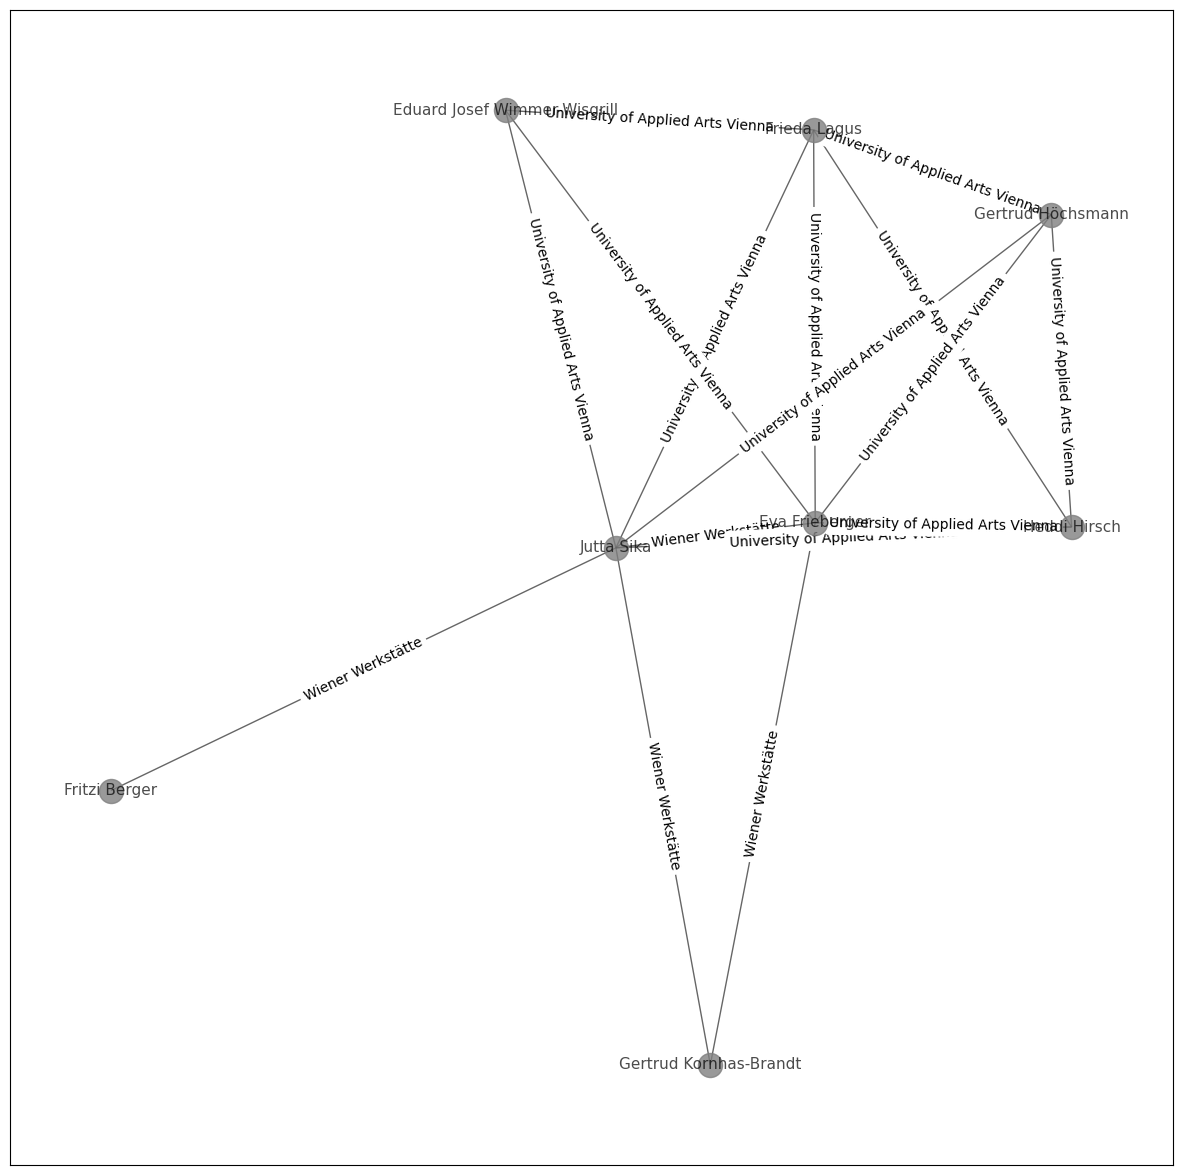

In [494]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,15))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

pos = nx.spring_layout(u, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)



plt.show()

**Commentaire**
On observe ici la composant du graph qui met en évidence les créateurs.trices de mode liés aux institutions de formation de la ville d'Anvers. Le réseau est particulièrement dense, puisqu'il représente ce qui est couremment appelé "les six d'Anvers".

" Les « Six d'Anvers » sont six élèves de l'Académie royale des beaux-arts d'Anvers, en Belgique, issus de la même promotion au début des années 1980. Ces étudiants, futurs stylistes de renommée internationale, sont considérés comme l'avant-garde de la mode belge s'associant le plus souvent à la tendance minimaliste apparue à la fin des années 1980."

https://fr.wikipedia.org/wiki/Six_d%27Anvers#:~:text=Le%20groupe%20d'Anvers%20est,est%20associ%C3%A9%20temporairement%20Martin%20Margiela.

### Période 1971_2021

In [495]:
end20_pairs = [p for p in pairs_p if ((p[0]['periode']=='1971_2021') & (p[1]['periode']=='1971_2021'))]

In [496]:
### Préparer pour créer le graphe
l2 = []
for i in end20_pairs: #personnes ayan été en lien pour la période 1971_2021
    l2.append(tuple((i[0]['itemLabel'],i[1]['itemLabel'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}",
                                                              'organisation': i[0]['organisationLabel'] })))
l2[:4]

[('Abderrahmane Trabsini',
  'Hilde Sinke',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Royal Academy of Art'}),
 ('Abderrahmane Trabsini',
  'Lotte van Laatum',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Royal Academy of Art'}),
 ('Abderrahmane Trabsini',
  'Sara Vrugt',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Royal Academy of Art'}),
 ('Abiodun Folashade Tokunbo',
  'Ruggedman',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Lagos State University'})]

In [497]:
EMP2=nx.Graph()

In [498]:
EMP2.add_edges_from(l2)

In [499]:
nodes = list(EMP2.nodes.data())
nodes[:5]

[('Abderrahmane Trabsini', {}),
 ('Hilde Sinke', {}),
 ('Lotte van Laatum', {}),
 ('Sara Vrugt', {}),
 ('Abiodun Folashade Tokunbo', {})]

In [500]:
edges = list(EMP2.edges.data())
edges[:3]

[('Abderrahmane Trabsini',
  'Hilde Sinke',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Royal Academy of Art'}),
 ('Abderrahmane Trabsini',
  'Lotte van Laatum',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Royal Academy of Art'}),
 ('Abderrahmane Trabsini',
  'Sara Vrugt',
  {'relationship': 'educated_at_educated_at',
   'organisation': 'Royal Academy of Art'})]

In [501]:
labels = {}
for node in EMP2.nodes():
    labels[node] = node

In [502]:
###
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
# Créer un objet Network de PyVis avec l'option cdn_resources='remote'
nt = Network(notebook=True, cdn_resources='remote')
# populates the nodes and edges data structures
nt.from_nx(EMP2)
nt.prep_notebook()
# Générer le fichier HTML contenant la visualisation
#nt.show('graph2.html')
#display(HTML('graph2.html'))

**Commentaire**

On voit qu'il existe certains réseaux importants entouorés d'une constellation de micro-réseaux.

On observe ici l'émergence de nouveaux acteurs dans le monde de la création de mode comme des actrices ou des stars de la téléréalité qui sont isolées des réseaux principaux (outsiders) puisqu'elles n'ont pas de formation dans la mode et qu'il s'agit d'une activité annexe.




### Analyser les composantes du graphe

In [503]:
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]

(12, [18, 8, 5, 2, 2])

In [504]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]

In [505]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[0, 18], [5, 8], [6, 5], [1, 2], [2, 2], [3, 2], [4, 2], [7, 2]]

In [506]:
li=[n[0] for n in ln]

### Représenter le graphe

In [507]:
u = nx.Graph()
for i in li[1:3]:
    u = nx.union(u, S[i])

In [508]:
u = S[5]

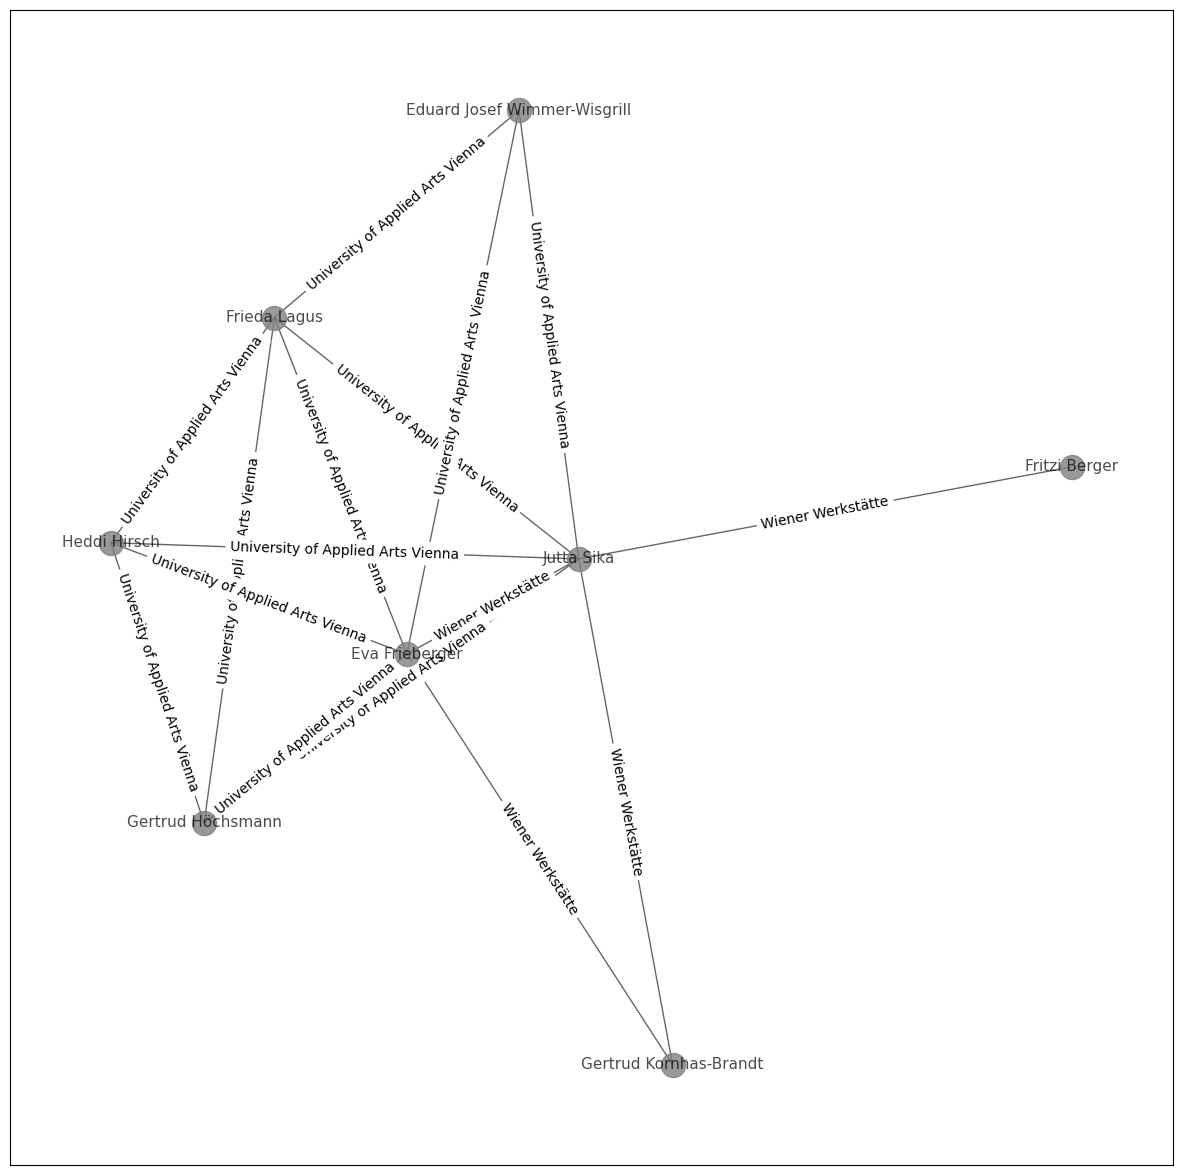

In [509]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,15))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

pos = nx.spring_layout(u, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)


plt.show()

## Explorer le graph des organisations (relation Alma Mater)

In [510]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'itemLabel': 'Aarni Soivio',
   'r_property': 'member_of',
   'organisationLabel': 'Kuumaa',
   'YBegin': 2024,
   'YEnd': 2061,
   'birthYear': 1997,
   'periode': '1971_2021'},
  {'itemLabel': 'Aarni Soivio',
   'r_property': 'educated_at',
   'organisationLabel': 'Sibelius Upper Secondary School',
   'YBegin': 2014,
   'YEnd': 2061,
   'birthYear': 1997,
   'periode': '1971_2021'}],
 [{'itemLabel': 'Abiodun Folashade Tokunbo',
   'r_property': 'educated_at',
   'organisationLabel': 'Lagos State University',
   'YBegin': 1997,
   'YEnd': 2044,
   'birthYear': 1980,
   'periode': '1971_2021'},
  {'itemLabel': 'Abiodun Folashade Tokunbo',
   'r_property': 'educated_at',
   'organisationLabel': 'The Polytechnic, Ibadan',
   'YBegin': 1997,
   'YEnd': 2044,
   'birthYear': 1980,
   'periode': '1971_2021'}]]

In [511]:
l3 = []
for i in pairs_o:
    if i[0]['r_property'] == 'educated_at' or  i[1]['r_property'] == 'educated_at':
        l3.append(tuple((i[0]['organisationLabel'],i[1]['organisationLabel'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}",
                                                              'personne': i[0]['itemLabel'] })))
len(l), l3[:3]

(98,
 [('Kuumaa',
   'Sibelius Upper Secondary School',
   {'relationship': 'member_of_educated_at', 'personne': 'Aarni Soivio'}),
  ('Lagos State University',
   'The Polytechnic, Ibadan',
   {'relationship': 'educated_at_educated_at',
    'personne': 'Abiodun Folashade Tokunbo'}),
  ('Lagos State University',
   'The Polytechnic, Ibadan',
   {'relationship': 'educated_at_educated_at',
    'personne': 'Abiodun Folashade Tokunbo'})])

In [512]:
### Graphe des organisation, liens AlmaMater

amO=nx.Graph()

In [513]:
amO.add_edges_from(l3)

In [514]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
amO.is_multigraph(),nx.is_connected(amO) , amO.number_of_nodes(), amO.number_of_edges(), nx.density(amO)

(False, False, 1138, 1525, 0.002357203691767408)

In [515]:
nodes = list(amO.nodes.data())
nodes[:5]

[('Kuumaa', {}),
 ('Sibelius Upper Secondary School', {}),
 ('Lagos State University', {}),
 ('The Polytechnic, Ibadan', {}),
 ('Cornell University', {})]

In [516]:
edges = list(amO.edges.data())
edges[:5]

[('Kuumaa',
  'Sibelius Upper Secondary School',
  {'relationship': 'member_of_educated_at', 'personne': 'Aarni Soivio'}),
 ('Lagos State University',
  'The Polytechnic, Ibadan',
  {'relationship': 'educated_at_educated_at',
   'personne': 'Abiodun Folashade Tokunbo'}),
 ('Cornell University',
  'Nichols School',
  {'relationship': 'educated_at_educated_at', 'personne': 'Adam Lippes'}),
 ('Cornell University',
  'Gallatin School of Individualized Study',
  {'relationship': 'educated_at_educated_at', 'personne': 'Lynn Ban'}),
 ('Cornell University',
  'Agnes Irwin School',
  {'relationship': 'educated_at_educated_at', 'personne': 'Vanessa Noel'})]

### Analyser les composantes du graph

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [517]:
components = nx.connected_components(amO);
components_l = [len(c) for c in sorted(nx.connected_components(amO), key=len, reverse=True)]
len(components_l), components_l[:5]

(187, [567, 23, 20, 18, 11])

In [518]:
largest_cc = max(nx.connected_components(amO), key=len); type(largest_cc)

set

In [519]:
S = amO.subgraph(largest_cc).copy()

In [520]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
S.is_multigraph(),nx.is_connected(S) , S.number_of_nodes(), S.number_of_edges(), nx.density(S)

(False, True, 567, 1030, 0.0064190052411489396)

### Centralité de degré

"La centralité de degré se mesure au nombre de liens (taille du réseau d’un acteur). On peut l’interpréter en disant que plus un acteur est central, plus il est « actif » dans le système."

https://helios2.mi.parisdescartes.fr/~lerb/a_pedagogiques/Rapports/QRS_Rapport%202002/Florentine/Rapport2.html

In [521]:
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [522]:
nx.set_node_attributes(amO, degree)
print(list(amO.nodes.data())[:3])

[('Kuumaa', {}), ('Sibelius Upper Secondary School', {}), ('Lagos State University', {})]


### Centralité de proximité

"La centralité de proximité d’un acteur se mesure au nombre minimum de pas qu’il doit effectuer pour entrer en contact avec les autres acteurs du système. De ce point de vue, plus un acteur est central, plus il est « proche » des autres, plus il entre vite en contact ou interagit facilement avec eux. On l’interprète parfois comme une mesure d’autonomie, d’indépendance à l’égard du contrôle exercé par d’autres."

https://helios2.mi.parisdescartes.fr/~lerb/a_pedagogiques/Rapports/QRS_Rapport%202002/Florentine/Rapport2.html

In [523]:
closeness = nx.closeness_centrality(amO)

In [524]:
nx.set_node_attributes(amO, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

"La centralité d’intermédiarité est basée sur l’idée du contrôle exercé par l’acteur sur les interactions entre deux autres acteurs. Lorsque deux acteurs ne sont pas adjacents, ils dépendent d’autres acteurs du groupe pour leurs échanges, en particulier des acteurs qui se trouvent sur le chemin entre eux et qui ont la capacité d’interrompre la circulation des ressources."

https://helios2.mi.parisdescartes.fr/~lerb/a_pedagogiques/Rapports/QRS_Rapport%202002/Florentine/Rapport2.html

In [525]:
betweenness = nx.betweenness_centrality(amO)

In [526]:
nx.set_node_attributes(amO, betweenness, 'betweenness')

In [527]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(amO.nodes.data(), columns = ['id', 'attributes'])
#export = export.set_index('id')
export.head()

,id,attributes
0,Kuumaa,"{'closeness': 0.0008795074758135445, 'betweenn..."
1,Sibelius Upper Secondary School,"{'closeness': 0.0008795074758135445, 'betweenn..."
2,Lagos State University,"{'closeness': 0.0008795074758135445, 'betweenn..."
3,"The Polytechnic, Ibadan","{'closeness': 0.0008795074758135445, 'betweenn..."
4,Cornell University,"{'degree': 3, 'closeness': 0.09115350919499315..."


In [528]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
pd.options.display.float_format = '{: }'.format  # pour 4 chiffres : 4f


round(attributes, 4)

,closeness,betweenness,degree
0,0.0009,0.0,NaN
1,0.0009,0.0,NaN
2,0.0009,0.0,NaN
3,0.0009,0.0,NaN
4,0.0912,0.0017,3.0
...,...,...,...
1133,0.0009,0.0,NaN
1134,0.0009,0.0,NaN
1135,0.0012,0.0,NaN
1136,0.0009,0.0,NaN


In [529]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
# export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export = export.join(attributes)
export = export.drop(columns=['attributes'],axis=1)
export.head()

,id,closeness,betweenness,degree
0,Kuumaa,0.0008795074758135445,0.0,NaN
1,Sibelius Upper Secondary School,0.0008795074758135445,0.0,NaN
2,Lagos State University,0.0008795074758135445,0.0,NaN
3,"The Polytechnic, Ibadan",0.0008795074758135445,0.0,NaN
4,Cornell University,0.09115350919499315,0.0017481759510448798,3.0


In [530]:
round(export.sort_values(by=['degree'], ascending=False).head(20),3)

,id,closeness,betweenness,degree
47,Parsons School of Design,0.158,0.081,65.0
42,Central Saint Martins,0.157,0.085,62.0
70,Fashion Institute of Technology,0.173,0.123,46.0
56,Royal College of Art,0.131,0.022,31.0
26,Fashion Institute of Design & Merchandising,0.126,0.014,18.0
135,Saint Martin's School of Art,0.142,0.02,17.0
156,Art Students League of New York,0.141,0.017,16.0
232,Beaux-Arts de Paris,0.095,0.007,16.0
108,New York University,0.139,0.009,16.0
23,Bunka Fashion College,0.083,0.011,14.0


In [531]:
export['degree'].describe()
## permet de filter la population > la majorité des individu à un degré 4 ou moins ( 1,2,3)

count                567.0
mean       3.6331569664903
std      5.046724552472974
min                    1.0
25%                    1.0
50%                    2.0
75%                    4.0
max                   65.0
Name: degree, dtype: float64

**Commentaire**

La majorité des individus (troisième quartile)  aun degré de 4 ou moins et les valeurs vont de 1 à 65. Il y a donc une grande dispersion des données.

In [532]:
kamo = nx.k_core(amO, k=5)

In [533]:
### Principales caractéristiques de ce graph

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
kamo.is_multigraph(),nx.is_connected(kamo) , kamo.number_of_nodes(), kamo.number_of_edges(), nx.density(kamo)

(False, False, 48, 151, 0.13386524822695037)

In [534]:
components = nx.connected_components(kamo);
components_l = [len(c) for c in sorted(nx.connected_components(kamo), key=len, reverse=True)]
len(components_l), components_l[:5]

(4, [21, 15, 6, 6])

In [535]:
largest_cc = max(nx.connected_components(kamo), key=len)

In [536]:
new_cc = sorted(nx.connected_components(kamo), key=len, reverse=True)[1]


In [537]:
S = kamo.subgraph(new_cc).copy()

### Représenter le graph

In [538]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html
u = S
## ,nx.is_connected(G_1971_1975) u.is_directed(),
u.is_multigraph(), nx.is_connected(u), u.number_of_nodes(), u.number_of_edges(), nx.density(u)

(False, True, 15, 57, 0.5428571428571428)

In [539]:
list(u.nodes.data())[1:3]

[('Beverly Hills High School',
  {'degree': 6,
   'closeness': 0.10241930095300757,
   'betweenness': 0.0029254792014231207}),
 ('Free Kitten',
  {'degree': 7, 'closeness': 0.09477144195147119, 'betweenness': 0.0})]

In [540]:
labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] >1:
        labels[i[0]]=i[0]
list(labels.items())[:3]

[('King George V School', 'King George V School'),
 ('Beverly Hills High School', 'Beverly Hills High School'),
 ('Free Kitten', 'Free Kitten')]

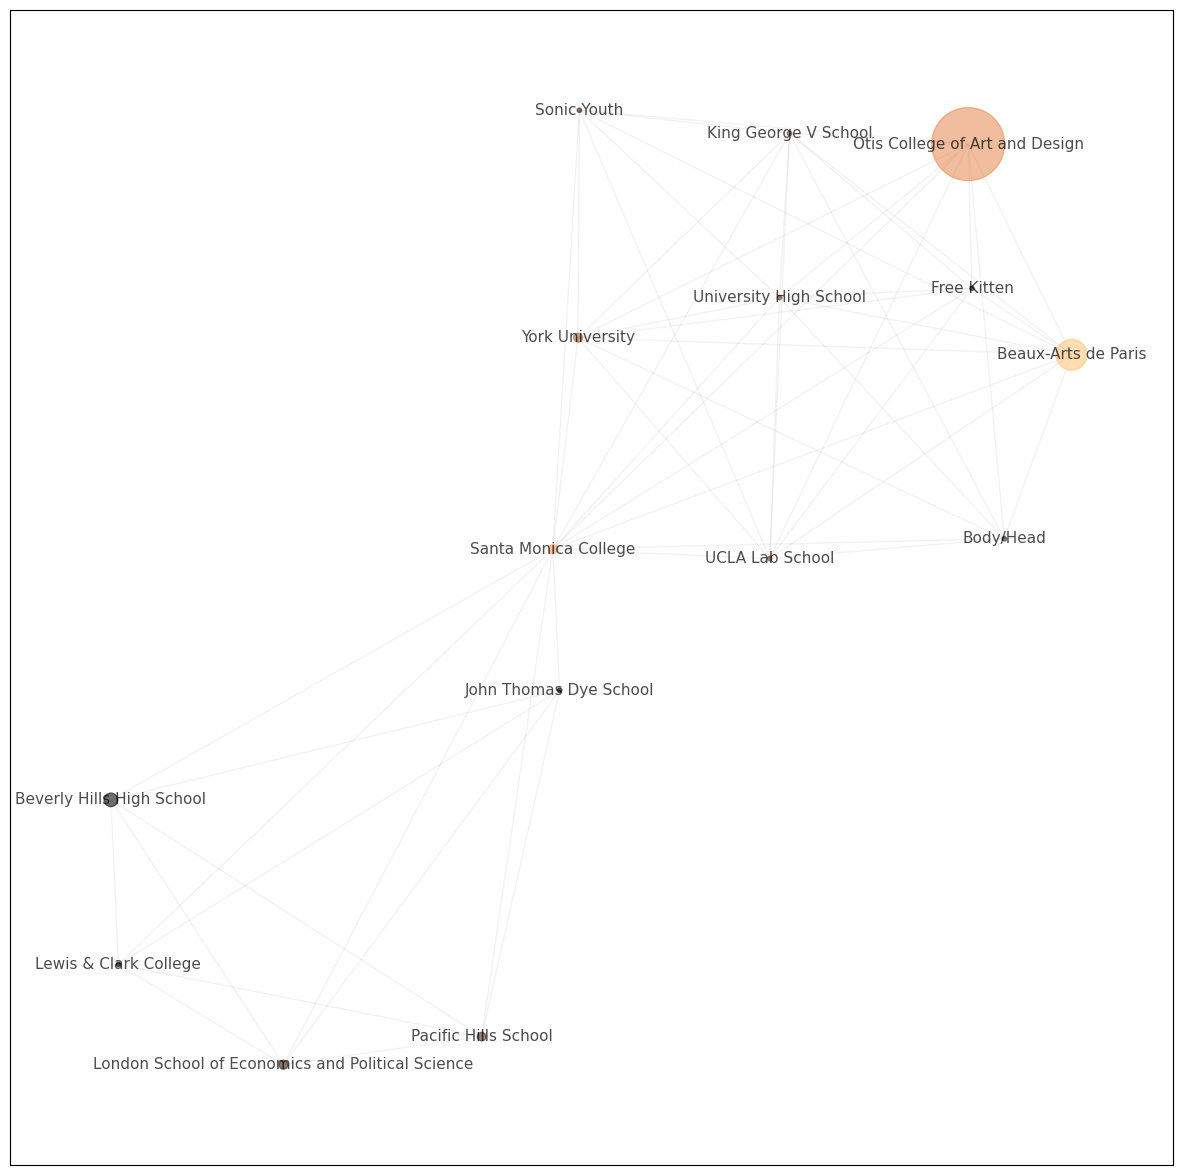

In [541]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (15,15))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 1:# degré filtre les résultats
        labels[i[0]]=i[0]

node_color = [i[1]['degree'] for i in list(u.nodes.data())]

### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['betweenness']**2 * 10000000 + 10 for i in list(u.nodes.data())] # visualisation de la taille


cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_color,
                      cmap='copper', alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.05) # edgelist=ln, edge_color=c,
nx.draw_networkx_labels(g, pos, labels=labels,  alpha=0.7, font_size=11)
#nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

f = 'pictures/universites.svg'# io.BytesIO()

plt.show()

**Commentaire**

On peut constater que les établissement où se sont formé.e.s les créateurs.trices de mode les plus connectés aux autres sont des établissements préuniversitaires (school) ou de premier niveau d'études universitaires ( college dans le système américain)

Ainsi, le Otis College of Arts & design occupe une place prépondérante et qui est justement reconnu comme une des meilleures formations de bachelor en mode aux Etats-Unis.

"Otis is known for its B.F.A. degree offered in fashion design. Under the direction of Rosemary Brantley, this program is considered one of the top fashion design programs of its kind in the U.S" ( Wikipedia)
https://en.wikipedia.org/wiki/Otis_College_of_Art_and_Design

Les Beaux-Arts de Paris occupent une place prépondérante.

**Commentaire général**

On pourrait complexifier l'analyse de réseaux pour voir s'il existe des réseaux spécifiques liés au grandes maisons rachetées par les groupes de luxes à partir des années 1990 (Kering et LVMH)

On pourrait aussi s'intéreser au rôle d'autres acteurs du monde de la mode, comme les journalistes en les ajoutant, pour voir par exemples s'ils/elles jouent le rôle de "broker", d'intermédiaires entre différents réseaux.
